#### Architecture - Semantic Search using Elastic Search


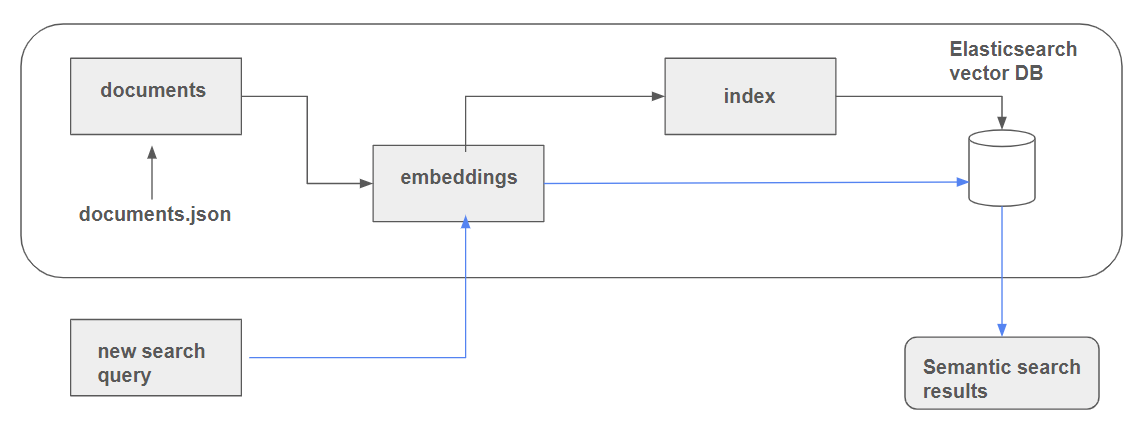

* Two very important concepts in Elasticsearch are documents and indexes.

* A document is collection of fields with their associated values. 

* To work with Elasticsearch you have to organize your data into documents, and then add all your documents to an index. - "isw-faq"

* Index as a collection of documents that is stored in a highly optimized format designed to perform efficient searches.

### 0. Converting from HTML to DOCX 

In [ ]:
from spire.doc import *
from spire.doc.common import *

import requests 

# Create a Document from an html link 

def html_to_doc(html_link, output_filename):

    """
    This function reads an html link
    and returns a doc file .

    """

    html_string= requests.get(f'{html_link}').content

    document = Document()
    section = document.AddSection()
    section.PageSetup.Margins.All = 72
    paragraph = section.AddParagraph()
    
    paragraph.AppendHTML(html_string)

    print("Appended HTMLSTRING TO file saving to file now ... ")
    
    document.SaveToFile(f"{output_filename}.docx", FileFormat.Docx)
    
    document.Close()

    return None 



In [ ]:
html_link = "https://www.interswitchgroup.com/faq/faq.html"
output_filename = "ISW_RAG"

In [ ]:
html_to_doc(html_link, output_filename)

### A. Preparing and updating the index 

#### Step 1: Prepare documents

In [1]:
import json
import tqdm

with open('isw_rebirth_faq_document.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

In [2]:
# section reassignment necessary to get every section on the same level
documents = []

for isw_dict in docs_raw:
    for doc in isw_dict['documents']:
        doc['subject'] = isw_dict['subject']
        documents.append(doc)

documents[1]

{'text': 'Click on the Transfer Money menu\nComplete the fields by inserting the account number, desired bank name and amount\nInsert Card Details, i.e. PAN, Expiry Date, CVV, PIN, Safetoken/OTP or Verve eCash PIN if you are transferring from your eCash account.',
 'question': 'How do I Transfer Money via Quickteller',
 'subject': 'isw_general_faq'}

#### Step 2: Create Embeddings using Pretrained Models

Sentence Transformers documentation here: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

#### managing space - https://docs.github.com/en/codespaces/troubleshooting/troubleshooting-creation-and-deletion-of-codespaces

In [3]:
#!pip install sentence_transformers==2.7.0

In [4]:
# This is a new library compared to the previous modules. 
# Please perform "pip install sentence_transformers==2.7.0"
from sentence_transformers import SentenceTransformer

# if you get an error do the following:
# 1. Uninstall numpy 
# 2. Uninstall torch
# 3. pip install numpy==1.26.4
# 4. pip install torch
# run the above cell, it should work
model = SentenceTransformer("all-mpnet-base-v2")

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
#!pip install ipywidgets --upgrade jupyter nbextension enable --py widgetsnbextension --sys-prefix


In [6]:
#documents[1]

#### Next cell Takes a few mins 

In [7]:
#created the dense vector using the pre-trained model
operations = []
for doc in tqdm.tqdm(documents):
    # Transforming the title into an embedding using the model
    doc["text_vector"] = model.encode(doc["text"]).tolist()
    operations.append(doc)

100%|███████████████████| 42/42 [00:08<00:00,  5.20it/s]


In [8]:
#operations[1]

#### Step 3: Setup ElasticSearch connection 

In [9]:
#!pip install elasticsearch

In [12]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()

ObjectApiResponse({'name': '89aeb0bc5113', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'sUSgGTZoRWqnlR7fqJVh7w', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [15]:
es_client.indices.get_alias()

ObjectApiResponse({'isw-rebirth-faq': {'aliases': {}}})

#### Step 4: Create Mappings and Index

* Mapping is the process of defining how a document, and the fields it contains, are stored and indexed.

* Each document is a collection of fields, which each have their own data type.

* We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the datatype of each field (e.g., string, integer, or date), and how those fields should be indexed and stored 



In [13]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "question": {"type": "text"},
            "subject": {"type": "keyword"} ,
            "text_vector": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"},
        }
    }
}

In [14]:
index_name = "isw-rebirth-faq"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'isw-rebirth-faq'})

#### Step 5: Add documents into index

In [16]:
for doc in operations:
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

#### Step 6: Create end user query

In [17]:
search_term = "loan"
vector_search_term = model.encode(search_term)

In [18]:
len(model.encode("telephone"))

768

In [19]:
#k means profide 5 nearest searches

search_term = "loan"
vector_search_term = model.encode(search_term)

query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000, 
}

In [20]:
res = es_client.search(index=index_name, knn=query, source=["text", "question", "course"])
res["hits"]["hits"]

[{'_index': 'isw-rebirth-faq',
  '_id': 'uIBy3JEB4wWSaoIjbT1d',
  '_score': 0.74169904,
  '_source': {'question': 'How can I request for a loan on my Quickteller mobile app?',
   'text': 'To request for a loan via the mobile app;\nTap on "Loan" from either the "Menu sidebar" or "Quick Services"\nTap on "Request Loan"\nProceed to select the preferred loan provider and accept the loan offer.\nSelect your preferred card or enter a new card where your loan will be credited to'}},
 {'_index': 'isw-rebirth-faq',
  '_id': 't4By3JEB4wWSaoIjbT1G',
  '_score': 0.7040783,
  '_source': {'question': 'How do I pay back my Loan',
   'text': "How do I repay online\nGo to www.quickteller.com/ils and select the lender you have a loan with\nEnter your phone number you used to apply and enter your email.\nConfirm amount to pay.\nEnter card details and complete repayment\nHow do I repay using the ATM\nInsert your ATM card and select the 'Quickteller' option\nSelect 'Pay Bills'\nSelect 'Others'\nEnter Bille

#### Step 7: Perform Keyword search with Semantic Search (Hybrid/Advanced Search)

In [32]:
# Note: I made a minor modification to the query shown in the notebook here
# (compare to the one shown in the video)
# Included "knn" in the search query (to perform a semantic search) along with the filter 

search_term = "loan"
vector_search_term = model.encode(search_term)

query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000, 
}

knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}

In [33]:
search_term = "loan"
vector_search_term = model.encode(search_term)

query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000, 
}

knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}


response = es_client.search(
    index=index_name,
    query={
        "match": {"subject": f"{subject}"},
    },
    knn=knn_query,
    size=5,
    explain = True
)

In [35]:
#response["hits"]["hits"]

### B. OPERATIONALIZNG THE RAG FLOW - with semantic search 

In [1]:
import os 
from openai import OpenAI

from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 


from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
def build_prompt(query, search_results):
    prompt_template = """
    You are course teaching assistant. Answer the QUESTION based on context from the FAQ databse.
    Use only the facts from the CONTEXT when answering the QUESTION 
    If the CONTEXT doesn't contain the answer , output NONE
    
    
    QUESTION: {question}
    
    CONTEXT: {context}
    
    """.strip()

    context = ""

    for doc in search_results:
        context = context + f"question: {doc['question']}\nanswer: {doc['text']}\n\n"


    prompt = prompt_template.format(question=query, context=context).strip()

    return prompt



In [60]:
# # RAG with semantic search 
# def elastic_search(query, subject) : 
    
#     index_name = "isw-rebirth-faq"
#     search_term = query
#     vector_search_term = model.encode(search_term)
    
    
#     knn_query = {
#         "field": "text_vector",
#         "query_vector": vector_search_term,
#         "k": 5,
#         "num_candidates": 10000
#     }
    
    
#     response = es_client.search(
#         index=index_name,
#         query={
#             "match": {"subject": f"{subject}"},
#         },
#         knn=knn_query,
#         size=5,
#         explain = True
#     )
    
    
#     #collecting the several documents into one List (Constant time complexity)
#     result_docs = [] 
    
#     for hit in response['hits']['hits']:
#         result_docs.append(hit['_source'])

#     return result_docs


In [61]:
def elastic_search(query, subject=None):
    index_name = "isw-rebirth-faq"
    search_term = query
    vector_search_term = model.encode(search_term)
    
    knn_query = {
        "field": "text_vector",
        "query_vector": vector_search_term,
        "k": 5,
        "num_candidates": 10000
    }
    
    if subject and subject in ["isw_general_faq", "qt_rebirth_faq"]:
        response = es_client.search(
            index=index_name,
            query={
                "match": {"subject": f"{subject}"},
            },
            knn=knn_query,
            size=5,
            explain=True
        )
    else:
        response = es_client.search(
            index=index_name,
            knn=knn_query,
            size=5,
            explain=True
        )
    
    # Collecting the several documents into one list (Constant time complexity)
    result_docs = []
    
    for hit in response['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs


In [62]:
# modularizing the logic for invoking the gpt 

def llm(prompt):
    client = OpenAI(api_key = os.environ['OPENAI_API_KEY'])
    response = client.chat.completions.create(
    model='gpt-4o-mini',
    messages=[{"role":'user', "content":prompt}])

    return response.choices[0].message.content

In [63]:
#Adjusting the RAG workflow to use the elastic search index mappings

# modularized calls 
def rag(query, subject=None):
 
    search_results = elastic_search(query, subject)
    
    prompt = build_prompt(query, search_results)
    
    answer = llm(prompt)

    return answer

In [87]:
query = "How can I upgrage my Quickteller account?"

In [88]:
#isw_general_faq
#qt_rebirth_faq

In [89]:
rag(query)

'To remove a card from Quickteller, follow these steps:\n1. Sign into the Quickteller platform.\n2. Click on wallet and navigate to Bank Cards.\n3. Select the card you wish to remove.\n4. Click on remove to remove the saved card.'

### C. Evaluating Performance with Subject Switching

In [68]:
import time 

In [55]:
start_time = time.time()
result = rag(query, subject="nincompoods")
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds",result)

Execution time: 0.6951439380645752 seconds To view your ecash, you need to sign in to Quickteller and navigate to your wallet, as your ecash is now located there.


In [56]:
start_time = time.time()
result = rag(query, subject="qt_rebirth_faq")
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds", result)

Execution time: 0.6781909465789795 seconds To view your eCash, sign in to Quickteller and navigate to your wallet, as your eCash is now located there.


In [57]:
start_time = time.time()
result = rag(query, subject="isw_general_faq")
end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds", result)

Execution time: 0.8158679008483887 seconds Your ecash is now located in your wallet. To view your ecash, sign in to Quickteller and navigate to wallet to view your eCash balance.


### D. References

1. https://logz.io/blog/elasticsearch-mapping/#:~:text=Within%20a%20search%20engine%2C%20mapping,indexes%20and%20stores%20its%20fields

2. https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

3. https://www.elastic.co/search-labs/tutorials

4. https://www.elastic.co/search-labs/blog/text-similarity-search-with-vectors-in-elasticsearch